# Sina Weibo prediction

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

RANDOM_STATE=8402

2024-04-17 09:30:00.634426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 09:30:00.634494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 09:30:00.636857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Defining the loss function

In [4]:
def mixed_loss(y_true: ArrayLike, y_pred: ArrayLike, bias=[5,3,3], scaling=[.5,.25,.25], thresold=.8):
    precision = 1 - np.sum((np.abs(y_pred-y_true)/(y_true + bias)) * scaling, axis=0)
    sgn_precision = precision > threshold
    count_row_sum = np.sum(np.clip(y_true, a_min=None, a_max=100), axis=1) + 1
    return np.sum(count_row_sum * sgn_precision) / np.sum(count_row_sum)

misex_scorer = make_scorer(mixed_loss, greater_is_better=False)

## Dataset preperation

In [5]:
def file_to_df(filename, col_names=['uid', 'mid', 'ts', 'forward_n', 'comment_n', 'like_n', 'content']):
    """Helper to parse data. Contains hardcoded logic"""
    df = pd.read_csv(filename, sep='\t', names=col_names)
    if 'ts' in col_names:
        df['ts'] = pd.to_datetime(df['ts'])
    return df

In [6]:
Xy_tv = file_to_df('/kaggle/input/sna-weibo-data/Weibo Data/weibo_train_data(new)/weibo_train_data.txt')
X_tv = Xy_tv.drop(['forward_n', 'comment_n', 'like_n'], axis=1)
y_tv = Xy_tv[['forward_n', 'comment_n', 'like_n']].replace([np.inf, -np.inf], np.nan)

## Data analysis

### Navive analysis

In [7]:
def embedd(
    data,
    vectorizer=TfidfVectorizer(stop_words='english', max_features=250),
    reducer=umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2)
):
    embeddings = vectorizer.fit_transform(data)
    return reducer.fit_transform(embeddings)


In [19]:
embeddings = embedd(X_tv.content.sample(100_000, random_state=RANDOM_STATE))

/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


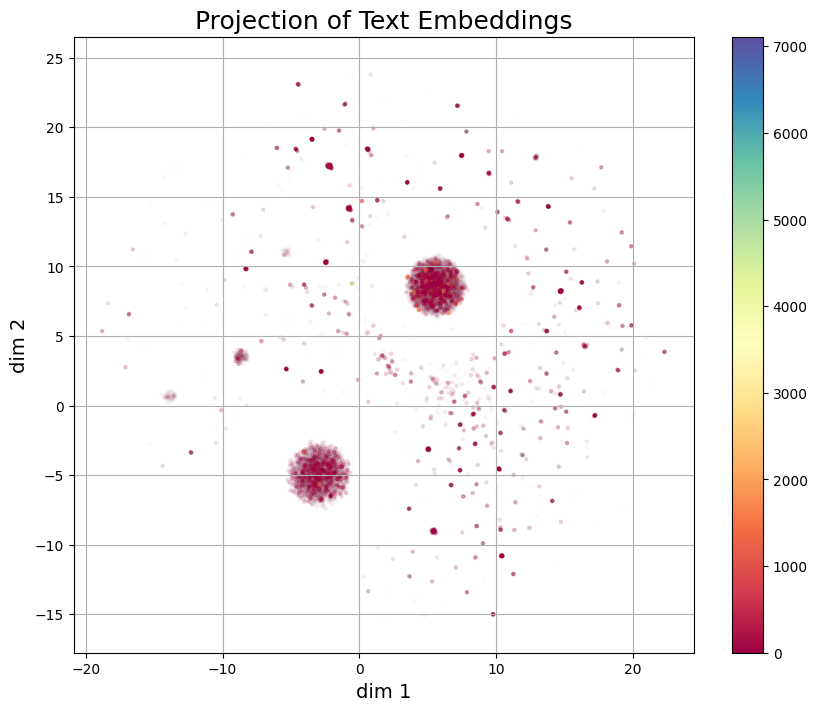

In [22]:
categories = np.sum(y_tv.sample(100_000, random_state=RANDOM_STATE) * [.5, .25, .25], axis=1)
alhpa_vals = np.log10(categories / categories.max() + 0.01) / np.log10(1.01)
scaled_alpha_vals = np.clip((alhpa_vals - alhpa_vals.min()) / (alhpa_vals.max() - alhpa_vals.min()), a_min=None, a_max=1)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=categories,
    cmap='Spectral',
    s=5,
    alpha=scaled_alpha_vals
)
plt.colorbar(scatter)
plt.title('Projection of Text Embeddings', fontsize=18)
plt.xlabel('dim 1', fontsize=14)
plt.ylabel('dim 2', fontsize=14)
plt.grid(True)
plt.show()

### Target analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


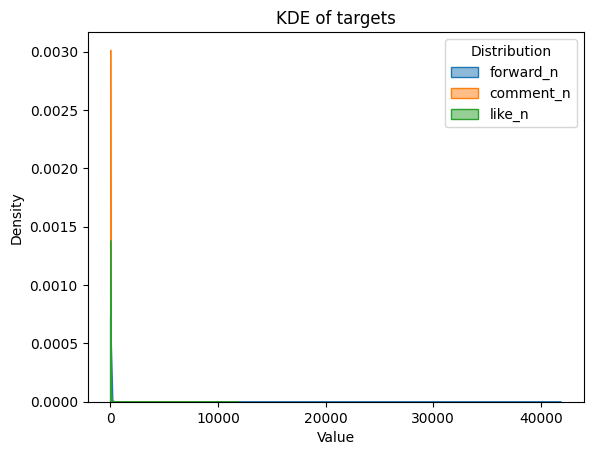

In [11]:
for column in y_tv.columns:
    sns.kdeplot(y_tv[column], label=column, fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of targets')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Distribution')

## Model definition

In [12]:
models: list[tuple[str,BaseEstimator]] = [
    ('base-0', DummyRegressor(strategry='constant', constant=[0,0,0]))
]

## Eval

In [13]:
ts_cv = TimeSeriesSplit()

In [14]:
scores = {n: cross_val_score(m, X_tv, y_tv, cv=ts_cv) for n, m in models}

In [ ]:
scores